In [2]:
# importing packages

import numpy as np
import os
import time
from dask import dataframe as dd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import vitaldb
import csv
from datetime import datetime, time as datetime_time, timedelta
import glob
import sys
import sklearn.neighbors._base
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

In [3]:
from pyexpat import features
from random import Random
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import vitaldb
import csv
from datetime import datetime, time as datetime_time, timedelta
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

from sklearn.feature_selection import SelectPercentile, RFECV, mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EXFS
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
 
from sklearn.preprocessing import OrdinalEncoder
import argparse
import pickle
from pathlib import Path

In [71]:
n_cpus = os.cpu_count()

In [72]:
from boruta import BorutaPy
import xgboost as xgb

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [5]:
def getRootDir():
    """
    Get root folder directory
    :return: root folder directory
    :rtype: path
    """
    rootdir = os.path.abspath(os.curdir)

    return rootdir

In [6]:
rootdir = getRootDir()
rootdir

'/Users/tselanna/Desktop/Code'

In [76]:
# Import final shrinked & imputed dataset with all cases (1104)
df = glob.glob(os.path.join(
        rootdir, 'TOSHIBA_HDD/2022_07_06T17_09_07_1104cases_IMP_SHRINK_FINAL.csv'))
df = pd.read_csv(df[0], low_memory=False)

In [77]:
# Delete 17 useless variables
df = df.drop(['department', 'optype', 'dx', 'opname', 'approach', 'position', 'ane_type', 'preop_ecg', 'preop_pft',
             'iv1', 'airway', 'emop', 'icu_days', 'tubesize', 'anedur', 'extdur', 'los'], axis=1)

In [78]:
df.shape

(3585370, 61)

In [79]:
df.isna().sum().sum()

0

In [ ]:
# Create a smaller dataset with 50 random cases on which to perform RFE

In [80]:
ids = set(df['caseid'])
ids

{1,
 4097,
 6146,
 6148,
 2054,
 4103,
 4104,
 6150,
 2059,
 6156,
 4110,
 2065,
 18,
 4114,
 2068,
 21,
 4117,
 4119,
 2073,
 4121,
 2076,
 6173,
 30,
 2078,
 33,
 2082,
 4130,
 2084,
 6180,
 6181,
 2094,
 50,
 2100,
 2102,
 2103,
 2104,
 57,
 2105,
 2107,
 2108,
 2109,
 62,
 63,
 4154,
 4158,
 4159,
 4160,
 2116,
 4161,
 6210,
 71,
 6214,
 6218,
 2124,
 2126,
 2128,
 6225,
 6226,
 4087,
 6231,
 88,
 4185,
 90,
 4186,
 6232,
 6236,
 95,
 6241,
 100,
 6244,
 2155,
 6251,
 109,
 6253,
 116,
 6263,
 6265,
 124,
 127,
 4224,
 129,
 4225,
 6272,
 2180,
 133,
 4229,
 135,
 6276,
 140,
 2190,
 6288,
 6294,
 4248,
 2201,
 4249,
 2203,
 6300,
 6137,
 159,
 2207,
 4257,
 166,
 2215,
 6315,
 2220,
 173,
 174,
 4269,
 6316,
 6317,
 6319,
 179,
 6321,
 2229,
 6325,
 4279,
 6327,
 2235,
 192,
 4288,
 194,
 2242,
 196,
 4291,
 6338,
 2247,
 2248,
 6340,
 6342,
 6347,
 207,
 2255,
 4303,
 6352,
 211,
 212,
 6354,
 6356,
 2263,
 4312,
 2265,
 6358,
 6360,
 220,
 223,
 224,
 228,
 230,
 2278,
 4326,
 6

In [81]:
import random
n=50
random_ids = random.sample(ids, n)
random_ids

[4029,
 1955,
 4018,
 1634,
 5972,
 116,
 501,
 1864,
 4248,
 2567,
 1422,
 5968,
 3437,
 3362,
 4709,
 6265,
 4888,
 938,
 1483,
 1857,
 6352,
 640,
 2895,
 707,
 1147,
 2659,
 2107,
 3786,
 4114,
 4326,
 2116,
 4375,
 3677,
 2634,
 2683,
 930,
 4931,
 4249,
 5141,
 616,
 551,
 2953,
 4516,
 1859,
 5003,
 1819,
 1026,
 2745,
 6316,
 50]

In [82]:
small_df = df[df['caseid'].isin(random_ids)]

In [83]:
small_df.caseid.nunique()

50

In [163]:
small_df.shape

(138548, 61)

## Train/Test split

In [164]:
np.set_printoptions(threshold=np.inf)
idss = small_df.caseid.unique()
idss

array([  50,  116,  501,  551,  616,  640,  707,  930,  938, 1026, 1147,
       1422, 1483, 1634, 1819, 1857, 1859, 1864, 1955, 2107, 2116, 2567,
       2634, 2659, 2683, 2745, 2895, 2953, 3362, 3437, 3677, 3786, 4018,
       4029, 4114, 4248, 4249, 4326, 4375, 4516, 4709, 4888, 4931, 5003,
       5141, 5968, 5972, 6265, 6316, 6352])

In [165]:
# retain 80% of cases for training
train_ids = idss[0:40]
train_ids.shape

(40,)

In [166]:
# use the other 20% for testing
test_ids = idss[40:]
test_ids.shape

(10,)

In [167]:
train = df.loc[df['caseid'].isin(train_ids),]

In [168]:
train = train.drop(['caseid'], axis=1)

In [169]:
train.shape

(109257, 60)

In [170]:
test = df.loc[df['caseid'].isin(test_ids),]

In [171]:
test = test.drop(['caseid'], axis=1)

In [172]:
train.dtypes

age                      float64
sex                        int64
height                   float64
weight                   float64
bmi                      float64
asa                      float64
preop_htn                  int64
preop_dm                   int64
preop_hb                 float64
preop_plt                float64
preop_pt                 float64
preop_aptt               float64
preop_na                 float64
preop_k                  float64
preop_gluc               float64
preop_alb                float64
preop_ast                float64
preop_alt                float64
preop_bun                float64
preop_cr                 float64
intraop_ebl              float64
intraop_uo               float64
intraop_rbc                int64
intraop_ffp                int64
intraop_crystalloid      float64
intraop_colloid            int64
intraop_ppf                int64
intraop_mdz              float64
intraop_ftn                int64
intraop_rocu               int64
intraop_ve

In [187]:
# define train and test without SBP and MBP
target = 'Solar8000/NIBP_MBP'
x_train = train.drop([target, 'seconds', 'Solar8000/NIBP_SBP', 'Solar8000/NIBP_DBP'], axis=1)
y_train = train[target]
x_test = test.drop([target, 'seconds', 'Solar8000/NIBP_SBP', 'Solar8000/NIBP_DBP'], axis=1)
y_test = test[target]

In [189]:
# define train and test with SBP and MBP included
target = 'Solar8000/NIBP_MBP'
x_train = train.drop([target, 'seconds'], axis=1)
y_train = train[target]
x_test = test.drop([target, 'seconds'], axis=1)
y_test = test[target]

In [190]:
x_train.shape

(109257, 58)

In [116]:
y_train.shape

(109257,)

## Feature Selection

In [41]:
# Feature selection methods

def select_features(x, y, method='boruta', classifier=RandomForestRegressor()):
    if method == 'boruta':
        clf = classifier.fit(np.array(x),np.array(y))
        boruta_selector = BorutaPy(clf, n_estimators='auto', verbose=5)
        boruta_selector.fit(np.array(x),np.array(y))
        x_ = boruta_selector.transform(np.array(x))
        boruta_mask = boruta_selector.support_
        selected_features = []
        for bool, feature in zip(boruta_mask, x.columns):
            if bool:
                selected_features.append(feature)
        print('The best features are: {}'.format(selected_features))

    elif method == 'permutation':
        clf = classifier.fit(x,y)
        perm_importance = permutation_importance(clf, x, y, scoring='accuracy', n_jobs=n_cpus - 1)
        # features_sel = perm_importance.importances_mean.argsort()
        sorted_idx = np.argsort(perm_importance.importances_mean)
        print(sorted_idx)
        plt.barh(x.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
        plt.show()
        selected_features = x.columns[sorted_idx].tolist()

    elif method == 'rfe':
        rfe = RFECV(estimator=classifier, cv=5, n_features_to_select=58, n_jobs=n_cpus - 1, verbose=5)
        rfe.fit(x, y)
        x_ = rfe.transform(x)
        rfe_mask = rfe.get_support() 
        selected_features = []
        for bool, feature in zip(rfe_mask, x.columns):
            if bool:
                selected_features.append(feature)
        print('The best features are: {}'.format(selected_features))

    elif method == 'mutual':
        importances = mutual_info_classif(x,y)
        sorted_idx = np.argsort(importances)[::-1]
        plt.barh(x.columns[sorted_idx], importances[sorted_idx])
        plt.show()
        selected_features = x.columns[sorted_idx].tolist()

    elif method == 'gini':
        clf = classifier.fit(x,y)
        importances = clf.feature_importances_
        print(importances)
        sorted_idx = np.argsort(importances)[::-1]
        print(sorted_idx)
        plt.barh(x.columns[sorted_idx], importances[sorted_idx])
        plt.show()
        selected_features = x.columns[sorted_idx].tolist()

    elif method == 'ffs':
        ffs = SFS(classifier, k_features='best', forward=True, verbose=2, scoring='accuracy', cv=5, n_jobs=-1)
        ffs = ffs.fit(x, y)
        selected_features = list(ffs.k_feature_names_)
    
    elif method == 'bfs':
        bfs = SFS(classifier, k_features='best', forward=False, verbose=2, scoring='accuracy', cv=5, n_jobs=-1)
        bfs = bfs.fit(x, y)
        selected_features = list(bfs.k_feature_names_)

    elif method == 'exfs':
        exfs = EXFS(classifier, min_features=8, max_features=14, scoring='accuracy', cv=5, n_jobs=-1)
        exfs.fit(x,y)
        selected_features = list(exfs.best_idx_)

    return selected_features

## Gini index

[9.24708099e-04 9.00779240e-05 4.72074033e-04 5.51517909e-03
 5.54035225e-03 2.40630979e-04 8.11752245e-04 3.28435586e-04
 2.42844764e-03 1.25609157e-03 2.92690117e-03 5.36186455e-03
 9.67178191e-04 1.50743773e-03 1.08077370e-03 4.79540461e-04
 1.03248698e-03 7.56806056e-04 1.63944792e-03 1.17595908e-03
 5.85345193e-04 5.14724803e-04 8.01669336e-06 0.00000000e+00
 5.03599042e-04 5.40384501e-06 3.36586902e-04 0.00000000e+00
 2.70123365e-04 7.14773509e-04 0.00000000e+00 3.82474173e-04
 2.02993561e-05 0.00000000e+00 2.00911129e-05 5.86651844e-05
 4.46143948e-03 2.20064792e-03 2.06064296e-03 1.85273865e-04
 1.05799446e-03 9.23950804e-04 7.90688215e-04 2.88467536e-04
 8.00538396e-05 8.79983284e-03 6.08081220e-04 9.48292430e-04
 9.42416245e-04 1.69491682e-03 1.01141091e-04 2.24158284e-01
 7.06444091e-01 1.54988313e-03 1.23690154e-03 1.19335134e-03
 1.87683600e-03 4.40565000e-04]
[52 51 45  4  3 11 36 10  8 37 38 56 49 18 53 13  9 54 55 19 14 40 16 12
 47 48  0 41  6 42 17 29 46 20 21 24 15  

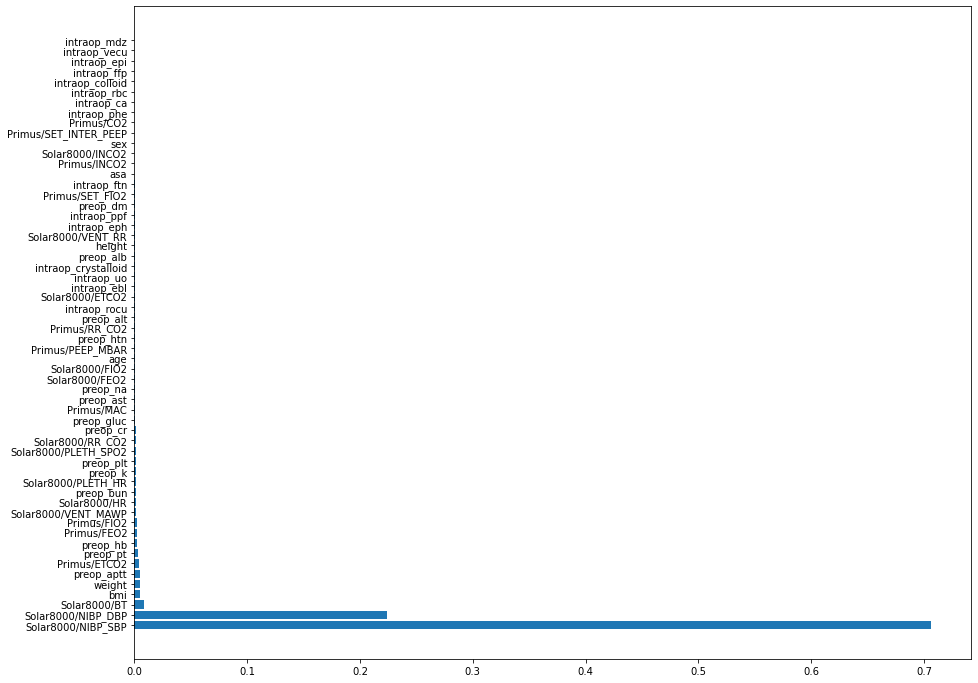

In [175]:
# Gini index when SBP and DBP included
gini = RandomForestRegressor().fit(x_train,y_train)
importances = gini.feature_importances_
print(importances)
sorted_idx = np.argsort(importances)[::-1]
print(sorted_idx)
plt.figure(figsize=(15,12))
plt.barh(x_train.columns[sorted_idx], importances[sorted_idx])
plt.show()
selected_features = x_train.columns[sorted_idx].tolist()

In [176]:
selected_features

['Solar8000/NIBP_SBP',
 'Solar8000/NIBP_DBP',
 'Solar8000/BT',
 'bmi',
 'weight',
 'preop_aptt',
 'Primus/ETCO2',
 'preop_pt',
 'preop_hb',
 'Primus/FEO2',
 'Primus/FIO2',
 'Solar8000/VENT_MAWP',
 'Solar8000/HR',
 'preop_bun',
 'Solar8000/PLETH_HR',
 'preop_k',
 'preop_plt',
 'Solar8000/PLETH_SPO2',
 'Solar8000/RR_CO2',
 'preop_cr',
 'preop_gluc',
 'Primus/MAC',
 'preop_ast',
 'preop_na',
 'Solar8000/FEO2',
 'Solar8000/FIO2',
 'age',
 'Primus/PEEP_MBAR',
 'preop_htn',
 'Primus/RR_CO2',
 'preop_alt',
 'intraop_rocu',
 'Solar8000/ETCO2',
 'intraop_ebl',
 'intraop_uo',
 'intraop_crystalloid',
 'preop_alb',
 'height',
 'Solar8000/VENT_RR',
 'intraop_eph',
 'intraop_ppf',
 'preop_dm',
 'Primus/SET_FIO2',
 'intraop_ftn',
 'asa',
 'Primus/INCO2',
 'Solar8000/INCO2',
 'sex',
 'Primus/SET_INTER_PEEP',
 'Primus/CO2',
 'intraop_phe',
 'intraop_ca',
 'intraop_rbc',
 'intraop_colloid',
 'intraop_ffp',
 'intraop_epi',
 'intraop_vecu',
 'intraop_mdz']

[4.71050085e-03 1.59272605e-03 5.87647293e-03 9.26693015e-03
 1.76456737e-02 7.56943769e-04 2.36549092e-02 1.12731447e-02
 3.17296162e-03 2.27315487e-03 4.55631936e-03 1.02424944e-02
 2.27057682e-02 9.56929319e-03 2.87598000e-02 3.15590349e-03
 4.63779144e-03 2.50338933e-03 2.10108994e-03 1.44842651e-02
 1.97427568e-03 6.94000651e-03 4.05336761e-05 0.00000000e+00
 3.05134920e-03 5.43804464e-03 3.27688581e-02 0.00000000e+00
 1.48462534e-01 1.84537309e-03 0.00000000e+00 1.00047644e-02
 6.97734493e-03 0.00000000e+00 7.36868888e-05 1.12507214e-02
 8.02388829e-02 3.31302673e-02 2.95923297e-02 6.42619336e-03
 3.52476713e-02 7.88124618e-03 1.82421541e-02 1.01299381e-02
 4.60867837e-04 9.36949384e-02 2.98031504e-02 1.42959226e-02
 9.84699316e-03 2.55218622e-02 3.18591631e-03 4.11664967e-02
 2.01677445e-02 2.39813219e-02 9.05935658e-02 1.46255125e-02]
[28 45 54 36 51 40 37 26 46 38 14 49 53  6 12 52 42  4 55 19 47  7 35 11
 43 31 48 13  3 41 32 21 39  2 25  0 16 10 50  8 15 24 17  9 18 20 29  1

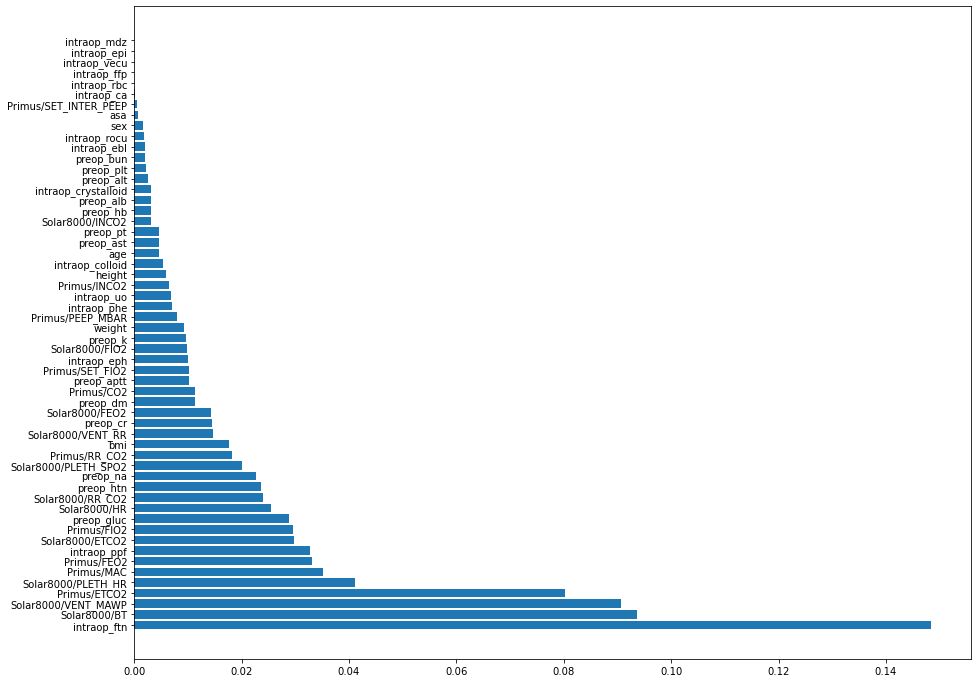

In [178]:
# Gini index when SBP and DBP are excluded
gini = RandomForestRegressor().fit(x_train,y_train)
importances = gini.feature_importances_
print(importances)
sorted_idx = np.argsort(importances)[::-1]
print(sorted_idx)
plt.figure(figsize=(15,12))
plt.barh(x_train.columns[sorted_idx], importances[sorted_idx])
plt.show()
selected_features = x_train.columns[sorted_idx].tolist()

In [179]:
selected_features

['intraop_ftn',
 'Solar8000/BT',
 'Solar8000/VENT_MAWP',
 'Primus/ETCO2',
 'Solar8000/PLETH_HR',
 'Primus/MAC',
 'Primus/FEO2',
 'intraop_ppf',
 'Solar8000/ETCO2',
 'Primus/FIO2',
 'preop_gluc',
 'Solar8000/HR',
 'Solar8000/RR_CO2',
 'preop_htn',
 'preop_na',
 'Solar8000/PLETH_SPO2',
 'Primus/RR_CO2',
 'bmi',
 'Solar8000/VENT_RR',
 'preop_cr',
 'Solar8000/FEO2',
 'preop_dm',
 'Primus/CO2',
 'preop_aptt',
 'Primus/SET_FIO2',
 'intraop_eph',
 'Solar8000/FIO2',
 'preop_k',
 'weight',
 'Primus/PEEP_MBAR',
 'intraop_phe',
 'intraop_uo',
 'Primus/INCO2',
 'height',
 'intraop_colloid',
 'age',
 'preop_ast',
 'preop_pt',
 'Solar8000/INCO2',
 'preop_hb',
 'preop_alb',
 'intraop_crystalloid',
 'preop_alt',
 'preop_plt',
 'preop_bun',
 'intraop_ebl',
 'intraop_rocu',
 'sex',
 'asa',
 'Primus/SET_INTER_PEEP',
 'intraop_ca',
 'intraop_rbc',
 'intraop_ffp',
 'intraop_vecu',
 'intraop_epi',
 'intraop_mdz']

In [150]:
cv_gini = np.mean(cross_val_score(RandomForestRegressor(), x_train, y_train, cv=5))

In [154]:
from sklearn.model_selection import cross_validate
cv_gini1 = cross_validate(RandomForestRegressor(), x_train, y_train, cv=5)

In [155]:
importances = cv_gini1.feature_importances_
print(importances)
sorted_idx = np.argsort(importances)[::-1]
print(sorted_idx)
plt.barh(x_train.columns[sorted_idx], importances[sorted_idx])
plt.show()
selected_features = x_train.columns[sorted_idx].tolist()

AttributeError: 'dict' object has no attribute 'feature_importances_'

In [158]:
# Try gini with cross validation

from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
rfr = RandomForestRegressor()
count = 1
feature_names = list(x_train.columns)


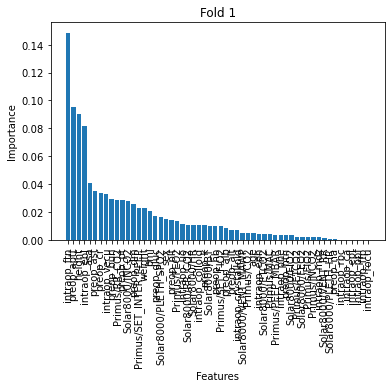

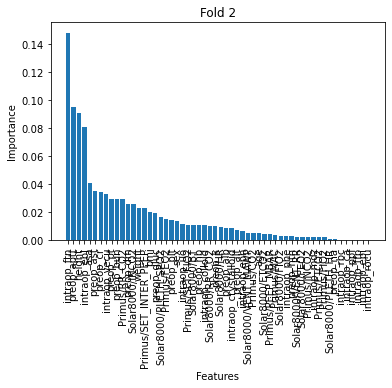

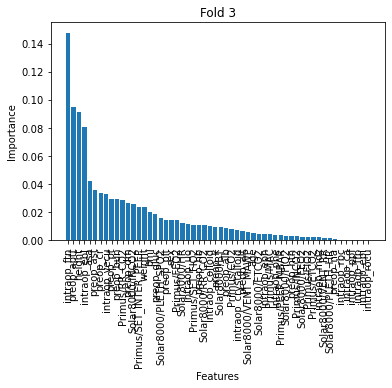

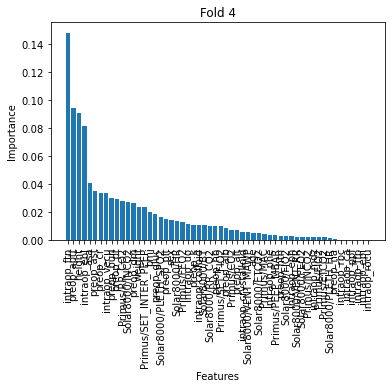

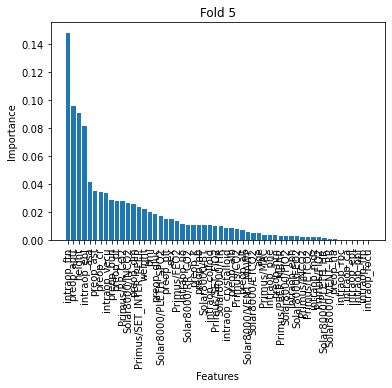

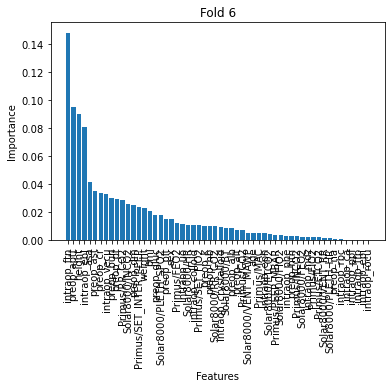

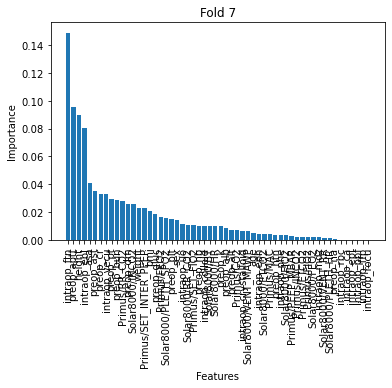

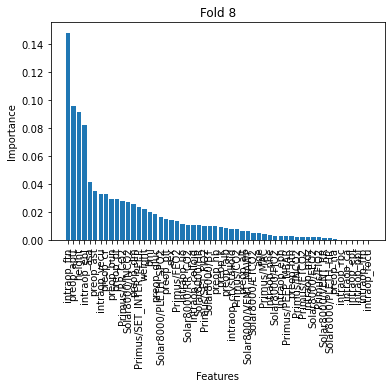

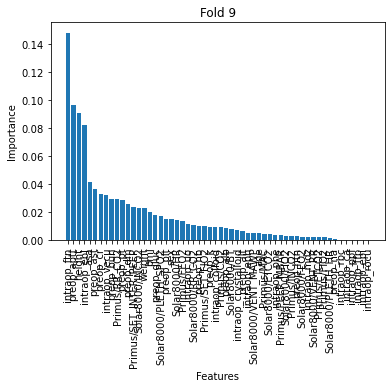

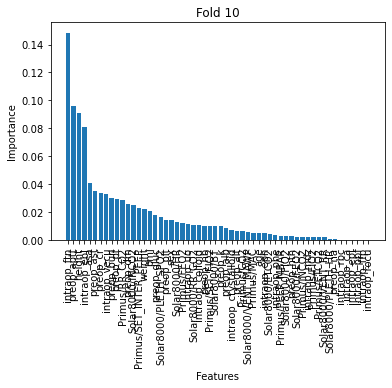

In [160]:
for train, _ in kf.split(x_train, y_train):
    rfr.fit(x_train, y_train)
    # sort the feature index by importance score in descending order
    importances_index_desc = np.argsort(rfr.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, rfr.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count = count + 1
plt.show()

In [148]:
x_test.shape

(29291, 56)

## RFE

In [123]:
x_train.dtypes

age                      float64
sex                        int64
height                   float64
weight                   float64
bmi                      float64
asa                      float64
preop_htn                  int64
preop_dm                   int64
preop_hb                 float64
preop_plt                float64
preop_pt                 float64
preop_aptt               float64
preop_na                 float64
preop_k                  float64
preop_gluc               float64
preop_alb                float64
preop_ast                float64
preop_alt                float64
preop_bun                float64
preop_cr                 float64
intraop_ebl              float64
intraop_uo               float64
intraop_rbc                int64
intraop_ffp                int64
intraop_crystalloid      float64
intraop_colloid            int64
intraop_ppf                int64
intraop_mdz              float64
intraop_ftn                int64
intraop_rocu               int64
intraop_ve

In [124]:
# RFE with cross validation
rfex = RFECV(estimator=RandomForestRegressor(), cv=5, n_jobs=n_cpus - 1, verbose=5)
rfe_out = rfex.fit(x_train, y_train)

Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.


[ 1  5  1  1  1  6  1  1  1  1  1  1  1  1  1  1  1  1  4  1  3  1  9 10
  1  1  1 13  1  2 12  1  1 11  8  1  1  1  1  1  1  1  1  1  7  1  1  1
  1  1  1  1  1  1  1  1]
[27 30 33 23 22 34 44  5  1 18 20 29  3 16 21 19  2 17 15  4 14 24 12 11
 10  9  8  7  6 13 55 25 42 53 52 51 50 49 48 47 46 45 43 41 26 40 39 38
 37 36 35 32 31 28 54  0]


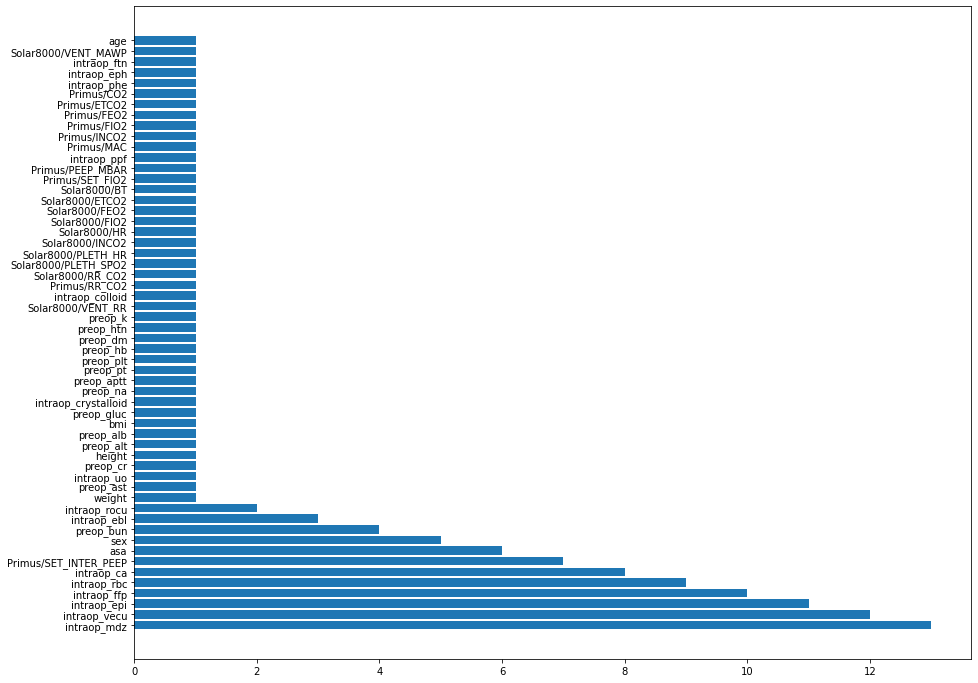

In [180]:
# Plot feature importance
importances = rfe_out.ranking_
print(importances)
sorted_idx = np.argsort(importances)[::-1]
print(sorted_idx)
plt.figure(figsize=(15,12))
plt.barh(x_train.columns[sorted_idx], importances[sorted_idx])
plt.show()
selected_features = x_train.columns[sorted_idx].tolist()

In [128]:
x_ = rfe_out.transform(x_train)
rfe_mask = rfe.get_support() 
selected_features = []
for bool, feature in zip(rfe_mask, x_train.columns):
    if bool:
            selected_features.append(feature)
print('The best features are: {}'.format(selected_features))

The best features are: ['age', 'sex', 'height', 'weight', 'bmi', 'asa', 'preop_htn', 'preop_dm', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun', 'preop_cr', 'intraop_ebl', 'intraop_uo', 'intraop_rbc', 'intraop_ffp', 'intraop_crystalloid', 'intraop_colloid', 'intraop_ppf', 'intraop_ftn', 'intraop_rocu', 'intraop_vecu', 'intraop_eph', 'intraop_phe', 'intraop_ca', 'Primus/CO2', 'Primus/ETCO2', 'Primus/FEO2', 'Primus/FIO2', 'Primus/INCO2', 'Primus/MAC', 'Primus/PEEP_MBAR', 'Primus/RR_CO2', 'Primus/SET_FIO2', 'Primus/SET_INTER_PEEP', 'Solar8000/BT', 'Solar8000/ETCO2', 'Solar8000/FEO2', 'Solar8000/FIO2', 'Solar8000/HR', 'Solar8000/INCO2', 'Solar8000/PLETH_HR', 'Solar8000/PLETH_SPO2', 'Solar8000/RR_CO2', 'Solar8000/VENT_MAWP', 'Solar8000/VENT_RR']


In [125]:
# Rank features
from operator import itemgetter
features = x_train.columns.to_list()
for x, y in (sorted(zip(rfe_out.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 age
1 height
1 weight
1 bmi
1 preop_htn
1 preop_dm
1 preop_hb
1 preop_plt
1 preop_pt
1 preop_aptt
1 preop_na
1 preop_k
1 preop_gluc
1 preop_alb
1 preop_ast
1 preop_alt
1 preop_cr
1 intraop_uo
1 intraop_crystalloid
1 intraop_colloid
1 intraop_ppf
1 intraop_ftn
1 intraop_eph
1 intraop_phe
1 Primus/CO2
1 Primus/ETCO2
1 Primus/FEO2
1 Primus/FIO2
1 Primus/INCO2
1 Primus/MAC
1 Primus/PEEP_MBAR
1 Primus/RR_CO2
1 Primus/SET_FIO2
1 Solar8000/BT
1 Solar8000/ETCO2
1 Solar8000/FEO2
1 Solar8000/FIO2
1 Solar8000/HR
1 Solar8000/INCO2
1 Solar8000/PLETH_HR
1 Solar8000/PLETH_SPO2
1 Solar8000/RR_CO2
1 Solar8000/VENT_MAWP
1 Solar8000/VENT_RR
2 intraop_rocu
3 intraop_ebl
4 preop_bun
5 sex
6 asa
7 Primus/SET_INTER_PEEP
8 intraop_ca
9 intraop_rbc
10 intraop_ffp
11 intraop_epi
12 intraop_vecu
13 intraop_mdz


In [110]:
# RFE without cross-validation
n_features_to_select = 1
rfe_ = RFE(RandomForestRegressor(), n_features_to_select=n_features_to_select, verbose=5)
rfe_1 = rfe_.fit(x_train, y_train)

Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 fe

In [111]:
# Rank features
from operator import itemgetter
features = x_train.columns.to_list()
for x, y in (sorted(zip(rfe_1.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 bmi
2 Solar8000/BT
3 Primus/ETCO2
4 intraop_ftn
5 Solar8000/PLETH_HR
6 Solar8000/VENT_MAWP
7 Primus/FEO2
8 Solar8000/RR_CO2
9 preop_gluc
10 Primus/FIO2
11 preop_cr
12 intraop_ppf
13 Primus/MAC
14 Solar8000/HR
15 preop_na
16 preop_htn
17 Solar8000/ETCO2
18 Primus/RR_CO2
19 intraop_uo
20 Solar8000/PLETH_SPO2
21 preop_k
22 Solar8000/FEO2
23 preop_dm
24 preop_aptt
25 Solar8000/VENT_RR
26 intraop_eph
27 weight
28 Primus/CO2
29 Primus/SET_FIO2
30 height
31 Solar8000/FIO2
32 intraop_phe
33 Primus/PEEP_MBAR
34 Primus/INCO2
35 preop_pt
36 age
37 intraop_crystalloid
38 preop_alb
39 preop_ast
40 intraop_colloid
41 preop_hb
42 preop_plt
43 Solar8000/INCO2
44 intraop_rocu
45 preop_alt
46 preop_bun
47 intraop_ebl
48 sex
49 asa
50 Primus/SET_INTER_PEEP
51 intraop_ca
52 intraop_rbc
53 intraop_ffp
54 intraop_vecu
55 intraop_epi
56 intraop_mdz


[36 48 30 27  1 49 16 23 41 42 35 24 15 21  9 38 39 45 46 11 47 19 52 53
 37 40 12 56  4 44 54 26 32 55 51 28  3  7 10 34 13 33 18 29 50  2 17 22
 31 14 43  5 20  8  6 25]
[27 33 30 23 22 34 44  5  1 20 18 17 29 50  9  8 25 16 15 24  0 10 39 41
 32 48  2 43 35  3 31 55 11  7 47 13 52 21 42 46  6 12 49 40 26 19 38 14
 53 37 54 51 28 36 45  4]


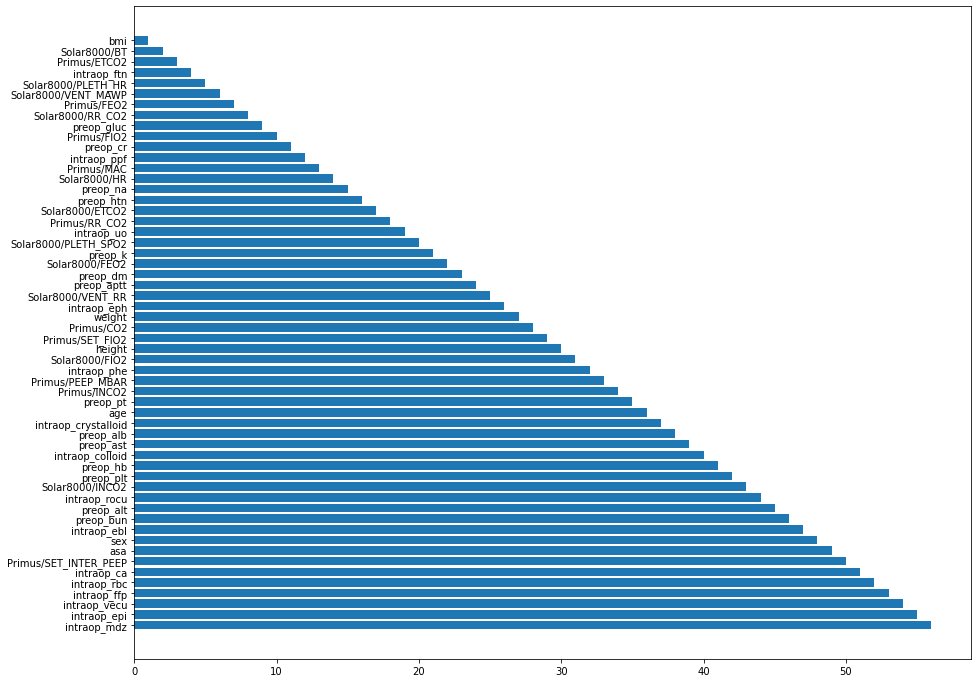

In [184]:
# Plot feature importance
importances = rfe_1.ranking_
print(importances)
sorted_idx = np.argsort(importances)[::-1]
print(sorted_idx)
plt.figure(figsize=(15,12))
plt.barh(x_train.columns[sorted_idx], importances[sorted_idx])
plt.show()

In [191]:
# RFE without cross-vcalidation AND including SBP and DBP
n_features_to_select = 1
rfe_bp = RFE(RandomForestRegressor(), n_features_to_select=n_features_to_select, verbose=5)
rfe_bpp = rfe_bp.fit(x_train, y_train)

Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 fe

In [192]:
# Rank features
from operator import itemgetter
features = x_train.columns.to_list()
for x, y in (sorted(zip(rfe_bpp.ranking_ , features), key=itemgetter(0))):
    print(x, y)

# https://www.kaggle.com/code/carlmcbrideellis/recursive-feature-elimination-rfe-example/notebook

1 Solar8000/NIBP_SBP
2 Solar8000/NIBP_DBP
3 bmi
4 Solar8000/BT
5 preop_aptt
6 weight
7 Primus/ETCO2
8 preop_bun
9 Primus/FEO2
10 preop_pt
11 Primus/FIO2
12 preop_hb
13 Solar8000/VENT_MAWP
14 Solar8000/HR
15 preop_plt
16 preop_k
17 preop_gluc
18 Solar8000/RR_CO2
19 Solar8000/PLETH_HR
20 preop_ast
21 preop_cr
22 Solar8000/PLETH_SPO2
23 Solar8000/FEO2
24 age
25 Primus/MAC
26 preop_na
27 Primus/PEEP_MBAR
28 preop_htn
29 intraop_uo
30 Solar8000/FIO2
31 Primus/RR_CO2
32 intraop_rocu
33 preop_alt
34 intraop_ebl
35 preop_alb
36 intraop_crystalloid
37 Solar8000/ETCO2
38 intraop_eph
39 Solar8000/VENT_RR
40 height
41 intraop_ppf
42 Primus/SET_FIO2
43 intraop_ftn
44 preop_dm
45 asa
46 Primus/INCO2
47 Solar8000/INCO2
48 Primus/SET_INTER_PEEP
49 sex
50 Primus/CO2
51 intraop_phe
52 intraop_ca
53 intraop_colloid
54 intraop_rbc
55 intraop_ffp
56 intraop_vecu
57 intraop_epi
58 intraop_mdz


[24 49 40  6  3 45 28 44 12 15 10  5 26 16 17 35 20 33  8 21 34 29 54 55
 36 53 41 58 43 32 56 38 51 57 52 50  7  9 11 46 25 27 31 42 48  4 37 23
 30 14 47  2  1 19 22 18 13 39]
[27 33 30 23 22 25 34 32 35  1 44 50 39  5  7 28 43 26  2 57 31 46 24 15
 20 17 29 42 48 21  6 41 12 40  0 47 54 19 16 53 55 14 13  9 49 56  8 38
 10 37 18 36  3 11 45  4 51 52]


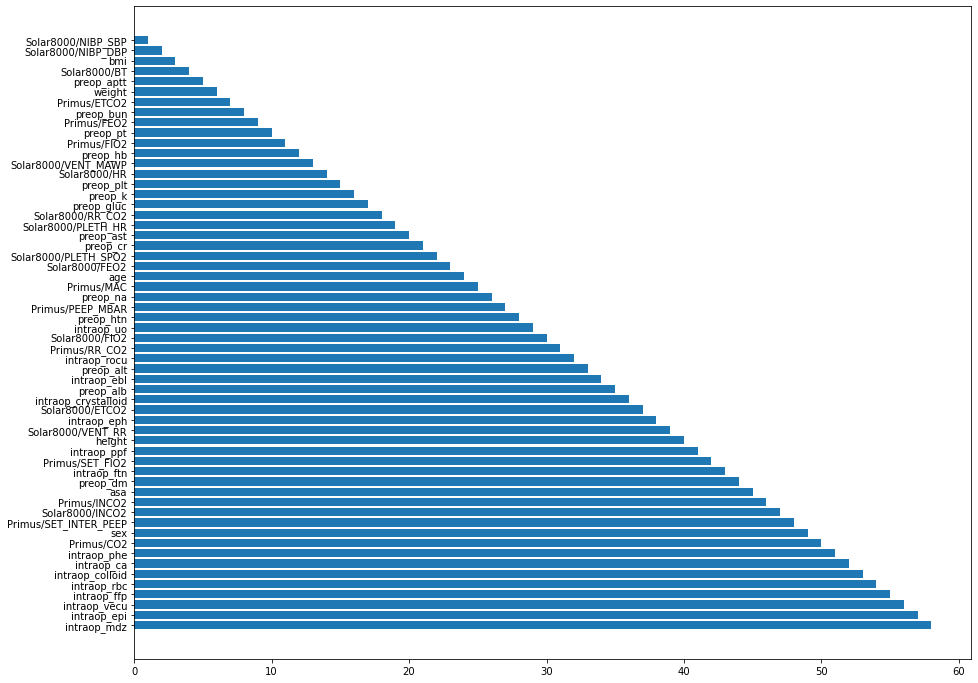

In [193]:
# Plot feature importance
importances = rfe_bpp.ranking_
print(importances)
sorted_idx = np.argsort(importances)[::-1]
print(sorted_idx)
plt.figure(figsize=(15,12))
plt.barh(x_train.columns[sorted_idx], importances[sorted_idx])
plt.show()

## Boruta

In [132]:
# Do boruta without SBP/DBP
boruta_selector = BorutaPy(RandomForestRegressor(), n_estimators='auto', verbose=5)
boruta_selector.fit(np.array(x_train),np.array(y_train))     

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	46
Tentative: 	2
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	46
Tentative: 	2
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	46
Tentative: 	2
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	46
Tentative: 	2
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	46
Tentative: 	2
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	46
Tentative: 	2
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	46
Tentative: 	2
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	46
Tentative: 	2
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	46
Tentative: 	2
Rejected: 	8
I

BorutaPy(estimator=RandomForestRegressor(n_estimators=97,
                                         random_state=RandomState(MT19937) at 0x7F9354FE4240),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F9354FE4240, verbose=5)

In [133]:
x_ = boruta_selector.transform(np.array(x_train))
boruta_mask = boruta_selector.support_
selected_features = []
for bool, feature in zip(boruta_mask, x_train.columns):
    if bool:
            selected_features.append(feature)
print('The best features are: {}'.format(selected_features))

The best features are: ['age', 'sex', 'height', 'weight', 'bmi', 'preop_htn', 'preop_dm', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun', 'preop_cr', 'intraop_ebl', 'intraop_uo', 'intraop_crystalloid', 'intraop_colloid', 'intraop_ppf', 'intraop_ftn', 'intraop_rocu', 'intraop_eph', 'intraop_phe', 'Primus/ETCO2', 'Primus/FEO2', 'Primus/FIO2', 'Primus/INCO2', 'Primus/MAC', 'Primus/PEEP_MBAR', 'Primus/RR_CO2', 'Primus/SET_FIO2', 'Solar8000/BT', 'Solar8000/ETCO2', 'Solar8000/FEO2', 'Solar8000/FIO2', 'Solar8000/HR', 'Solar8000/INCO2', 'Solar8000/PLETH_HR', 'Solar8000/PLETH_SPO2', 'Solar8000/RR_CO2', 'Solar8000/VENT_MAWP', 'Solar8000/VENT_RR']


In [134]:
# Rank features
from operator import itemgetter
features = x_train.columns.to_list()
for x, y in (sorted(zip(boruta_selector.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 age
1 sex
1 height
1 weight
1 bmi
1 preop_htn
1 preop_dm
1 preop_hb
1 preop_plt
1 preop_pt
1 preop_aptt
1 preop_na
1 preop_k
1 preop_gluc
1 preop_alb
1 preop_ast
1 preop_alt
1 preop_bun
1 preop_cr
1 intraop_ebl
1 intraop_uo
1 intraop_crystalloid
1 intraop_colloid
1 intraop_ppf
1 intraop_ftn
1 intraop_rocu
1 intraop_eph
1 intraop_phe
1 Primus/ETCO2
1 Primus/FEO2
1 Primus/FIO2
1 Primus/INCO2
1 Primus/MAC
1 Primus/PEEP_MBAR
1 Primus/RR_CO2
1 Primus/SET_FIO2
1 Solar8000/BT
1 Solar8000/ETCO2
1 Solar8000/FEO2
1 Solar8000/FIO2
1 Solar8000/HR
1 Solar8000/INCO2
1 Solar8000/PLETH_HR
1 Solar8000/PLETH_SPO2
1 Solar8000/RR_CO2
1 Solar8000/VENT_MAWP
1 Solar8000/VENT_RR
2 Primus/CO2
3 asa
4 Primus/SET_INTER_PEEP
5 intraop_ca
6 intraop_rbc
8 intraop_ffp
8 intraop_mdz
8 intraop_vecu
8 intraop_epi


[1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 8 1 1 1 8 1 1 8 1 1 8 5 2 1
 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1]
[27 33 30 23 22 34 44  5 35  3 16 21 20  1 19 18  2 17 15  4 14 24 12 11
 10  9  8  7  6 13 55 25 42 53 52 51 50 49 48 47 46 45 43 41 26 40 39 38
 37 36 32 31 29 28 54  0]


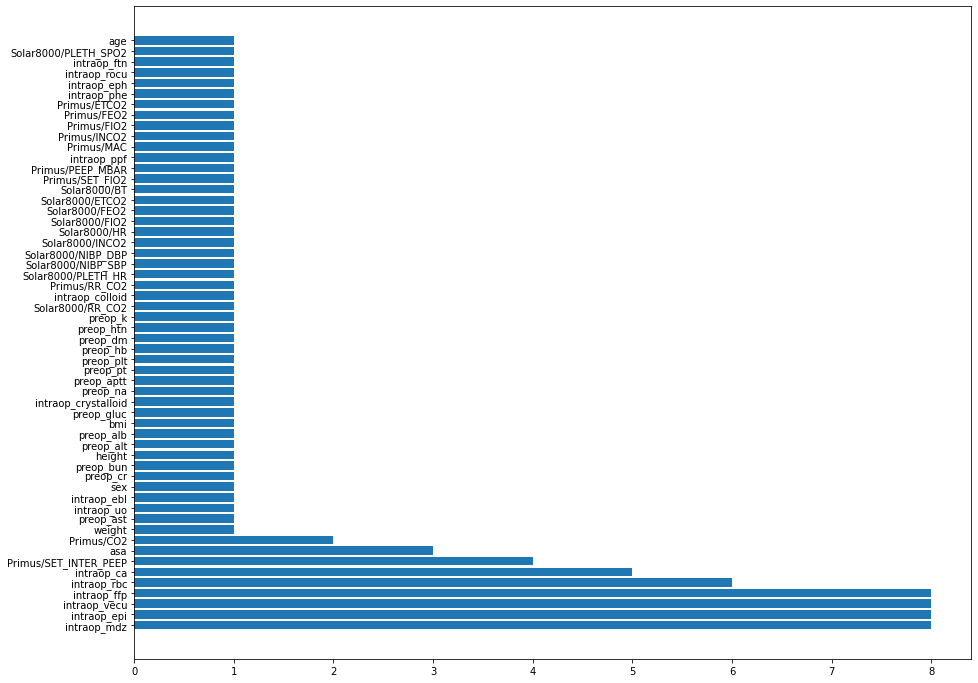

In [194]:
# Plot feature importance
importances = boruta_selector.ranking_
print(importances)
sorted_idx = np.argsort(importances)[::-1]
print(sorted_idx)
plt.figure(figsize=(15,12))
plt.barh(x_train.columns[sorted_idx], importances[sorted_idx])
plt.show()

In [195]:
x_train.dtypes

age                      float64
sex                        int64
height                   float64
weight                   float64
bmi                      float64
asa                      float64
preop_htn                  int64
preop_dm                   int64
preop_hb                 float64
preop_plt                float64
preop_pt                 float64
preop_aptt               float64
preop_na                 float64
preop_k                  float64
preop_gluc               float64
preop_alb                float64
preop_ast                float64
preop_alt                float64
preop_bun                float64
preop_cr                 float64
intraop_ebl              float64
intraop_uo               float64
intraop_rbc                int64
intraop_ffp                int64
intraop_crystalloid      float64
intraop_colloid            int64
intraop_ppf                int64
intraop_mdz              float64
intraop_ftn                int64
intraop_rocu               int64
intraop_ve

In [196]:
# Perform boruta with SBP/DBP
boruta_selector_2 = BorutaPy(RandomForestRegressor(), n_estimators='auto', verbose=5)
bs = boruta_selector_2.fit(np.array(x_train),np.array(y_train))     

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	46
Tentative: 	6
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	46
Tentative: 	6
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	46
Tentative: 	6
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	46
Tentative: 	6
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	47
Tentative: 	5
Rejected: 	6
Iteration: 	13 / 100
Confirmed: 	47
Tentative: 	5
Rejected: 	6
Iteration: 	14 / 100
Confirmed: 	47
Tentative: 	5
Rejected: 	6
Iteration: 	15 / 100
Confirmed: 	47
Tentative: 	5
Rejected: 	6
Iteration: 	16 / 100
Confirmed: 	47
Tentative: 	5
Rejected: 	6
I

In [197]:
# Rank features
from operator import itemgetter
features = x_train.columns.to_list()
for x, y in (sorted(zip(boruta_selector_2.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 age
1 sex
1 height
1 weight
1 bmi
1 asa
1 preop_htn
1 preop_dm
1 preop_hb
1 preop_plt
1 preop_pt
1 preop_aptt
1 preop_na
1 preop_k
1 preop_gluc
1 preop_alb
1 preop_ast
1 preop_alt
1 preop_bun
1 preop_cr
1 intraop_ebl
1 intraop_uo
1 intraop_crystalloid
1 intraop_ppf
1 intraop_ftn
1 intraop_rocu
1 intraop_eph
1 Primus/ETCO2
1 Primus/FEO2
1 Primus/FIO2
1 Primus/INCO2
1 Primus/MAC
1 Primus/PEEP_MBAR
1 Primus/RR_CO2
1 Primus/SET_FIO2
1 Primus/SET_INTER_PEEP
1 Solar8000/BT
1 Solar8000/ETCO2
1 Solar8000/FEO2
1 Solar8000/FIO2
1 Solar8000/HR
1 Solar8000/INCO2
1 Solar8000/NIBP_DBP
1 Solar8000/NIBP_SBP
1 Solar8000/PLETH_HR
1 Solar8000/PLETH_SPO2
1 Solar8000/RR_CO2
1 Solar8000/VENT_MAWP
1 Solar8000/VENT_RR
2 Primus/CO2
3 intraop_phe
4 intraop_colloid
5 intraop_rbc
5 intraop_ca
8 intraop_ffp
8 intraop_mdz
8 intraop_vecu
8 intraop_epi


## Drop unimportant variables

In [209]:
df.shape

(3585370, 61)

In [210]:
df_final = df.drop(['Primus/INCO2', 'Primus/SET_INTER_PEEP', 'Primus/CO2', 'Primus/FIO2', 'Primus/FEO2',
                    'Primus/RR_CO2', 'Primus/SET_FIO2', 'Primus/ETCO2', 'sex', 'intraop_phe', 'intraop_ca', 
'intraop_colloid', 'intraop_rbc', 'intraop_ffp', 'intraop_vecu', 'intraop_epi', 'intraop_mdz'], axis=1)

In [211]:
df_final.shape

(3585370, 44)

In [212]:
df_final

,caseid,age,height,weight,bmi,asa,preop_htn,preop_dm,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_gluc,preop_alb,preop_ast,preop_alt,preop_bun,preop_cr,intraop_ebl,intraop_uo,intraop_crystalloid,intraop_ppf,intraop_ftn,intraop_rocu,intraop_eph,Primus/MAC,Primus/PEEP_MBAR,Solar8000/BT,Solar8000/ETCO2,Solar8000/FEO2,Solar8000/FIO2,Solar8000/HR,Solar8000/INCO2,Solar8000/NIBP_DBP,Solar8000/NIBP_MBP,Solar8000/NIBP_SBP,Solar8000/PLETH_HR,Solar8000/PLETH_SPO2,Solar8000/RR_CO2,Solar8000/VENT_MAWP,Solar8000/VENT_RR,seconds
0,1,77.0,160.2,67.5,26.3,2.0,1,0,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,-1.0,300.0,350.0,120,100,70,10,0.0,1.0,21.100000,30.0,89.0,95.0,84.0,1.0,84.0,100.0,150.0,85.0,97.0,5.0,0.0,18.0,96
1,1,77.0,160.2,67.5,26.3,2.0,1,0,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,-1.0,300.0,350.0,120,100,70,10,0.0,1.0,21.100000,30.0,89.0,95.0,84.0,1.0,84.0,100.0,150.0,84.0,97.0,5.0,0.0,18.0,98
2,1,77.0,160.2,67.5,26.3,2.0,1,0,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,-1.0,300.0,350.0,120,100,70,10,0.0,1.0,21.000000,30.0,89.0,95.0,84.0,1.0,84.0,100.0,150.0,85.0,97.0,5.0,0.0,18.0,100
3,1,77.0,160.2,67.5,26.3,2.0,1,0,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,-1.0,300.0,350.0,120,100,70,10,0.0,1.0,21.000000,30.0,89.0,95.0,85.0,1.0,84.0,100.0,150.0,85.0,97.0,5.0,0.0,18.0,102
4,1,77.0,160.2,67.5,26.3,2.0,1,0,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,-1.0,300.0,350.0,120,100,70,10,0.0,1.0,21.000000,30.0,89.0,95.0,85.0,1.0,84.0,100.0,150.0,86.0,97.0,5.0,0.0,18.0,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3585365,6385,69.0,159.3,62.3,24.6,2.0,1,0,15.2,239.0,114.0,28.7,144.0,4.0,140.0,3.7,18.0,28.0,19.0,0.84,100.0,250.0,2500.0,100,0,100,25,0.2,2.0,36.400002,43.0,55.0,94.0,108.0,0.0,58.0,83.0,118.0,106.0,100.0,12.0,0.0,11.0,20076
3585366,6385,69.0,159.3,62.3,24.6,2.0,1,0,15.2,239.0,114.0,28.7,144.0,4.0,140.0,3.7,18.0,28.0,19.0,0.84,100.0,250.0,2500.0,100,0,100,25,0.2,2.0,36.400002,43.0,55.0,94.0,108.0,0.0,58.0,83.0,118.0,105.0,100.0,12.0,0.0,11.0,20078
3585367,6385,69.0,159.3,62.3,24.6,2.0,1,0,15.2,239.0,114.0,28.7,144.0,4.0,140.0,3.7,18.0,28.0,19.0,0.84,100.0,250.0,2500.0,100,0,100,25,0.2,2.0,36.400002,43.0,55.0,94.0,108.0,0.0,58.0,83.0,118.0,106.0,100.0,12.0,0.0,11.0,20080
3585368,6385,69.0,159.3,62.3,24.6,2.0,1,0,15.2,239.0,114.0,28.7,144.0,4.0,140.0,3.7,18.0,28.0,19.0,0.84,100.0,250.0,2500.0,100,0,100,25,0.2,2.0,36.400002,43.0,55.0,94.0,108.0,0.0,58.0,83.0,118.0,106.0,100.0,12.0,0.0,11.0,20082


## Further shrink dataset

In [7]:
# Import edited merged dataset
merged_df = glob.glob(os.path.join(
        rootdir, '*TOSHIBA_HDD/2022_06_20T13_36_10_Merged_edited.csv'))
merged_df = pd.read_csv(merged_df[0])
merged_df

/Users/tselanna/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (24,42,43,46) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,caseid,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,icu_days,death_inhosp,age,sex,height,weight,bmi,asa,emop,department,optype,dx,opname,approach,position,ane_type,preop_htn,preop_dm,preop_ecg,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_gluc,preop_alb,preop_ast,preop_alt,preop_bun,preop_cr,cormack,airway,tubesize,iv1,aline1,intraop_ebl,intraop_uo,intraop_rbc,intraop_ffp,intraop_crystalloid,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca,anedur,extdur,los,Primus/CO2,Primus/ETCO2,Primus/FEO2,Primus/FIO2,Primus/INCO2,Primus/MAC,Primus/PEEP_MBAR,Primus/RR_CO2,Primus/SET_FIO2,Primus/SET_INTER_PEEP,Solar8000/BT,Solar8000/ETCO2,Solar8000/FEO2,Solar8000/FIO2,Solar8000/HR,Solar8000/INCO2,Solar8000/NIBP_DBP,Solar8000/NIBP_MBP,Solar8000/NIBP_SBP,Solar8000/PLETH_HR,Solar8000/PLETH_SPO2,Solar8000/RR_CO2,Solar8000/VENT_MAWP,Solar8000/VENT_RR
0,1,5955,0,11520,-540,10860,-540,10380,-236220,627780,0,0,77.0,1,160.2,67.5,26.3,2.0,0,General surgery,Colorectal,Rectal cancer,Low anterior resection,Open,Lithotomy,General,1,0,Normal Sinus Rhythm,Normal,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,I,Oral,7.5,Right forearm,Left radial,NaN,300.0,0,0,350.0,0,120,0.0,100,70,0,10,0,0,0,190.0,8.0,7.145833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5955,0,11520,-540,10860,-540,10380,-236220,627780,0,0,77.0,1,160.2,67.5,26.3,2.0,0,General surgery,Colorectal,Rectal cancer,Low anterior resection,Open,Lithotomy,General,1,0,Normal Sinus Rhythm,Normal,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,I,Oral,7.5,Right forearm,Left radial,NaN,300.0,0,0,350.0,0,120,0.0,100,70,0,10,0,0,0,190.0,8.0,7.145833,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0,NaN,NaN,NaN,NaN,88.0,96.0,NaN,0.0,NaN
2,1,5955,0,11520,-540,10860,-540,10380,-236220,627780,0,0,77.0,1,160.2,67.5,26.3,2.0,0,General surgery,Colorectal,Rectal cancer,Low anterior resection,Open,Lithotomy,General,1,0,Normal Sinus Rhythm,Normal,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,I,Oral,7.5,Right forearm,Left radial,NaN,300.0,0,0,350.0,0,120,0.0,100,70,0,10,0,0,0,190.0,8.0,7.145833,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,5955,0,11520,-540,10860,-540,10380,-236220,627780,0,0,77.0,1,160.2,67.5,26.3,2.0,0,General surgery,Colorectal,Rectal cancer,Low anterior resection,Open,Lithotomy,General,1,0,Normal Sinus Rhythm,Normal,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,I,Oral,7.5,Right forearm,Left radial,NaN,300.0,0,0,350.0,0,120,0.0,100,70,0,10,0,0,0,190.0,8.0,7.145833,0.0,0.0,100.0,100.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,NaN,NaN,NaN,NaN,88.0,96.0,NaN,0.0,NaN
4,1,5955,0,11520,-540,10860,-540,10380,-236220,627780,0,0,77.0,1,160.2,67.5,26.3,2.0,0,General surgery,Colorectal,Rectal cancer,Low anterior resection,Open,Lithotomy,General,1,0,Normal Sinus Rhythm,Normal,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,I,Oral,7.5,Right forearm,Left radial,NaN,300.0,0,0,350.0,0,120,0.0,100,70,0,10,0,0,0,190.0,8.0,7.145833,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10421465,6385,2278,0,20640,-540,21000,-540,19800,-225600,1675200,0,0,69.0,1,159.3,62.3,24.6,2.0,0,General surgery,Colorectal,"Colon submucosal tumor, unknown behavior",Ultralow anterior resection,Videoscopic,Lithotomy,General,1,0,Normal Sinus Rhythm,Normal,15.2,239.0,114.0,28.7,144.0,4.0,140.0,3.7,18.0,28.0,19.0,0.84,NaN,NaN,7.5,

In [8]:
# Investigate cases that have been to the ICU
merged_df['icu_days'].value_counts()

0     9798641
1      431602
2       79056
3       36031
5       31936
4       17009
23      14156
8       13039
Name: icu_days, dtype: int64

In [10]:
# Caseids of those who went to the ICU
icu = merged_df.caseid[merged_df['icu_days'].gt(0)].unique()
icu.shape

(51,)

In [11]:
# first drop cases with >1 icu day so that we only keep later drop those that didnt go to the ICU
index_names = merged_df[merged_df['caseid'].isin(icu)].index
df = merged_df.drop(index_names) 
df.shape

(9798641, 89)

In [12]:
df.caseid.nunique()

1055

In [19]:
# 2 cases are under aged
age = merged_df.caseid[merged_df['age'].lt(18)].unique()
age

array([  90, 1911])

In [15]:
# Investigate operation time
optime = df.caseid[df['opend'].lt(7200)].unique()
optime.shape

(500,)

In [16]:
optime

array([  18,   33,   63,   71,   90,   95,  100,  127,  129,  159,  173,
        174,  179,  212,  223,  228,  240,  245,  248,  262,  272,  288,
        289,  292,  298,  302,  311,  331,  337,  340,  341,  346,  356,
        364,  370,  376,  410,  420,  424,  428,  429,  454,  471,  477,
        479,  482,  504,  508,  511,  528,  529,  538,  555,  556,  565,
        580,  583,  588,  598,  640,  647,  680,  682,  695,  710,  713,
        718,  724,  735,  804,  805,  823,  834,  838,  839,  854,  856,
        861,  888,  893,  897,  903,  938,  941,  951,  960,  961,  962,
        973, 1000, 1011, 1014, 1028, 1055, 1112, 1126, 1147, 1150, 1153,
       1161, 1223, 1235, 1247, 1252, 1270, 1296, 1306, 1318, 1326, 1330,
       1363, 1370, 1371, 1372, 1377, 1394, 1438, 1459, 1505, 1517, 1533,
       1550, 1557, 1582, 1598, 1606, 1634, 1643, 1650, 1659, 1686, 1713,
       1740, 1744, 1797, 1798, 1829, 1857, 1860, 1864, 1870, 1881, 1905,
       1909, 1911, 1940, 1946, 1955, 1962, 1972, 19

In [ ]:
# Drop 500 cases that have not been to the ICU but have operation time below 2 hours (including 2 cases under 18)

In [213]:
#  drop cases 
index_names = df_final[df_final['caseid'].isin(optime)].index
df_final2 = df_final.drop(index_names) 
df_final2.shape

(2370396, 44)

In [214]:
df_final2.caseid.nunique()

604

In [216]:
df_final2.shape

(2370396, 44)

In [217]:
df_final2.columns

Index(['caseid', 'age', 'height', 'weight', 'bmi', 'asa', 'preop_htn',
       'preop_dm', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt',
       'preop_na', 'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast',
       'preop_alt', 'preop_bun', 'preop_cr', 'intraop_ebl', 'intraop_uo',
       'intraop_crystalloid', 'intraop_ppf', 'intraop_ftn', 'intraop_rocu',
       'intraop_eph', 'Primus/MAC', 'Primus/PEEP_MBAR', 'Solar8000/BT',
       'Solar8000/ETCO2', 'Solar8000/FEO2', 'Solar8000/FIO2', 'Solar8000/HR',
       'Solar8000/INCO2', 'Solar8000/NIBP_DBP', 'Solar8000/NIBP_MBP',
       'Solar8000/NIBP_SBP', 'Solar8000/PLETH_HR', 'Solar8000/PLETH_SPO2',
       'Solar8000/RR_CO2', 'Solar8000/VENT_MAWP', 'Solar8000/VENT_RR',
       'seconds'],
      dtype='object')

In [215]:
# Export the final dataset

csv_filename = os.path.join(
            "TOSHIBA_HDD", f'{datetime.now().strftime("%Y_%m_%dT%H_%M_%S")}_ANALYSIS_DF_44var.csv')
df_final2.to_csv(csv_filename, encoding='utf-8-sig', index=False)